In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Transfer Learning

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [4]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)]),
    
    'val' : transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)]),
}

In [5]:
# import data
data_dir = 'hymenoptera_data'
sets = ['train', 'val']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('_'*10)
        
        # each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:.4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [48]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [50]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)

Epoch 0/1
__________
train Loss: 0.6962 Acc: 0.5325
val Loss: 0.5647 Acc: 0.7320

Epoch 1/1
__________
train Loss: 0.5584 Acc: 0.7317
val Loss: 0.4156 Acc: 0.8562

Training complete in 1m 47s
Best val acc: 0.8562


In [54]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.required_grad = False
    
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)

Epoch 0/1
__________
train Loss: 0.6283 Acc: 0.6626
val Loss: 0.4624 Acc: 0.8105

Epoch 1/1
__________
train Loss: 0.5126 Acc: 0.7846
val Loss: 0.3850 Acc: 0.8954

Training complete in 1m 51s
Best val acc: 0.8954


# Tensorboard

In [79]:
!pip install -q tb-nightly

In [80]:
%load_ext tensorboard

In [109]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 12104), started 1:09:39 ago. (Use '!kill 12104' to kill it.)

In [84]:
import sys
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist')

In [85]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
# hyper parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.001

In [87]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [88]:
examples = iter(train_loader)
example_data, example_targets = examples.next()

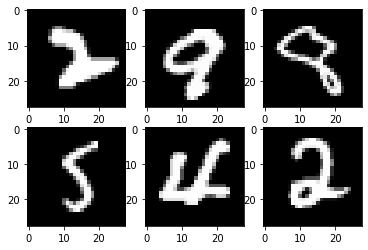

In [89]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
#plt.show()
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)
writer.close()

In [90]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [91]:
model = NeuralNet(input_size, hidden_size, num_classes)

In [92]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [93]:
writer.add_graph(model, example_data.reshape(-1, 28*28))
writer.close()

In [105]:
# training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        # 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss={loss.item():.4f}')
            writer.add_scalar('train loss', running_loss/100, epoch*n_total_steps + i)
            writer.add_scalar('acc', running_correct/100, epoch*n_total_steps + i)
            running_loss = 0.0
            running_correct = 0

epoch 1 / 1, step 100/938, loss=0.1248
epoch 1 / 1, step 200/938, loss=0.1127
epoch 1 / 1, step 300/938, loss=0.1442
epoch 1 / 1, step 400/938, loss=0.0926
epoch 1 / 1, step 500/938, loss=0.2043
epoch 1 / 1, step 600/938, loss=0.0496
epoch 1 / 1, step 700/938, loss=0.0548
epoch 1 / 1, step 800/938, loss=0.0637
epoch 1 / 1, step 900/938, loss=0.0808


In [108]:
# test
labels = []
preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels1 in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels1 = labels1.to(device)
        outputs = model(images)
        
        # value, index
        _, predicted = torch.max(outputs, 1)
        n_samples += labels1.shape[0]
        n_correct += (predicted == labels1).sum().item()
        
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_predictions)
        labels.append(predicted)
    
    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels = torch.cat(labels) 
    
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}')
    
    classes = range(10)
    for i in classes:
        labels_i = labels == i
        preds_i = preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

accuracy = 97.33


# Save and Load Model

In [4]:
# torch.save(arg, PATH)
# torch.load(PATH)
# model.load_state_dict(arg)

In [5]:
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [6]:
model = Model(n_input_features=6)

In [7]:
# train your model

In [16]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 0.2013, -0.3494, -0.0531, -0.3253,  0.3918, -0.3695]])), ('linear.bias', tensor([0.1933]))])


In [13]:
FILE = 'model.pth'
torch.save(model.state_dict(), FILE)

In [14]:
loaded_model = Model(n_input_features=6)
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.eval()

Model(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)

In [17]:
print(loaded_model.state_dict())

OrderedDict([('linear.weight', tensor([[ 0.2013, -0.3494, -0.0531, -0.3253,  0.3918, -0.3695]])), ('linear.bias', tensor([0.1933]))])


In [20]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(optimizer.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}


In [21]:
checkpoint = {
    'epoch': 90,
    'model_state': model.state_dict(),
    'optim_state': optimizer.state_dict()
} 

In [22]:
torch.save(checkpoint, 'checkpoint.pth')

In [23]:
loaded_checkpoint = torch.load('checkpoint.pth')
epoch = loaded_checkpoint['epoch']

In [24]:
model = Model(n_input_features=6)
optimizer = torch.optim.SGD(model.parameters(), lr=0)

In [26]:
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])

In [30]:
print(optimizer.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}


In [31]:
# save on gpu, load on cpu
"""
device = torch.device('cuda')
model.to(device)
torch.save(model.state_dict(), PATH)

device = torch.device('cpu')
model = Model(*args, **kwargs)
model.load_state_dict(torch.load(PATH, map_location=device))
"""

"\ndevice = torch.device('cuda')\nmodel.to(device)\ntorch.save(model.state_dict(), PATH)\n\ndevice = torch.device('cpu')\nmodel = Model(*args, **kwargs)\nmodel.load_state_dict(torch.load(PATH, map_location=device))\n"